## Imports

In [1]:
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from IPython.display import Markdown

from sklearn.model_selection import train_test_split, GridSearchCV, \
                            cross_val_score
from sklearn.dummy import DummyClassifier
# plot_confusion_matrix, plot_roc_curve
from sklearn.metrics import confusion_matrix, \
                            recall_score, accuracy_score, \
                            roc_curve, roc_auc_score, \
                            auc, \
                            RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, \
                            RandomForestRegressor, ExtraTreesRegressor
# from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier, \
                            KNeighborsRegressor

# from yellowbrick.classifier import ROCAUC
# from yellowbrick.classifier.rocauc import roc_auc

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

from code.model_verification import model_scoring, \
                        model_scoring_table

%matplotlib inline

In [2]:
sns.set()
sns.set(font_scale=2)

Import the `fetal_health.csv` data set, which is available
[here, via kaggle](https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification)  
<sup>kaggle data set was obtained via this research - 
[Ayres de Campos et al. (2000) SisPorto 2.0 A Program for Automated Analysis of Cardiotocograms. J Matern Fetal Med 5:311-318](https://onlinelibrary.wiley.com/doi/10.1002/1520-6661(200009/10)9:5%3C311::AID-MFM12%3E3.0.CO;2-9)</sup>

In [3]:
fetal_df = pd.read_csv('./data/fetal_health.csv')

In [4]:
fetal_df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [5]:
print(fetal_df.info(), \
    f"""\n\n
    Data shape: {fetal_df.shape}
    Total nulls in data set: {fetal_df.isna().sum().sum()}
    """)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

There are no nulls in this data set ... may not need to impute any data

all data is float64, may have some categories to pull out (such as
fetal health)

Let's go ahead and get the column names into formatted
titles for use later.

In [6]:
clean_titles = [column.replace('_',' ').title() for column in fetal_df.columns]

In [7]:
health_labels = ['Normal','Suspect','Pathological']

In [8]:
# display the columns that seem like they could be made
# into categorical variables, possibly at least 

print(f"""
{fetal_df.value_counts('fetal_health')}

{fetal_df.value_counts('histogram_number_of_peaks')}

{fetal_df.value_counts('histogram_number_of_zeroes')}
""")


fetal_health
1.0    1655
2.0     295
3.0     176
dtype: int64

histogram_number_of_peaks
1.0     357
2.0     331
3.0     269
4.0     258
5.0     210
6.0     158
7.0     145
0.0     107
8.0     106
9.0      67
10.0     49
11.0     28
12.0     22
13.0     10
14.0      5
16.0      2
15.0      1
18.0      1
dtype: int64

histogram_number_of_zeroes
0.0     1624
1.0      366
2.0      108
3.0       21
5.0        2
4.0        2
10.0       1
8.0        1
7.0        1
dtype: int64



The only column that seems to be able to be broken down into
a categorical value is the fetal_health column. 

### Checking the values

In [9]:
print(fetal_df.value_counts('fetal_health') , '\n\n' , fetal_df.value_counts('fetal_health', normalize=True))

fetal_health
1.0    1655
2.0     295
3.0     176
dtype: int64 

 fetal_health
1.0    0.778457
2.0    0.138758
3.0    0.082785
dtype: float64


From the [description of values in the dataset](./data/fetal_health_descriptions.md),
the values are heavily imbalanced in favor of "Normal" health.
1. Normal
2. Suspect
3. Pathological

## Determining the measure

Because the health of a child and mother are important,
the measure that this project will be employing will be
recall. It is imperative that as many suspect or
pathological cases are found as possible. An accidental
flag or false positive is more acceptable than missing
the cases where an issue is present.

This project will focus on maximizing the recall score
in an attempt to most accurately predict cases where a
pregnancy is showing potential signs of issues.

## Additional Data Preparation
### Defining X and y, creating splits

In [10]:
X = fetal_df.drop(columns=['fetal_health'])
y = fetal_df['fetal_health']

In [11]:
# we will stratify on the y values here to ensure that
# the proportion of the test and train data remains
# mostly the same, this is mostly to make sure that our
# test data actually has some of the values we are 
# targeting 
X_train, X_test, y_train, y_test = train_test_split(
                    X, y, random_state=1,
                    test_size=0.2, stratify=y
)

## Creating and Validating the Dummy Model

In [12]:
dummy_baseline = DummyClassifier(strategy='most_frequent')
dummy_baseline.fit(X_train,y_train)

DummyClassifier(strategy='most_frequent')

In [13]:
y_train_preds = dummy_baseline.predict(X_train)
y_train_preds

array([1., 1., 1., ..., 1., 1., 1.])

In [14]:
y_train

1391    1.0
926     1.0
111     1.0
1207    1.0
897     1.0
       ... 
2027    3.0
441     1.0
1449    1.0
1512    1.0
789     1.0
Name: fetal_health, Length: 1700, dtype: float64

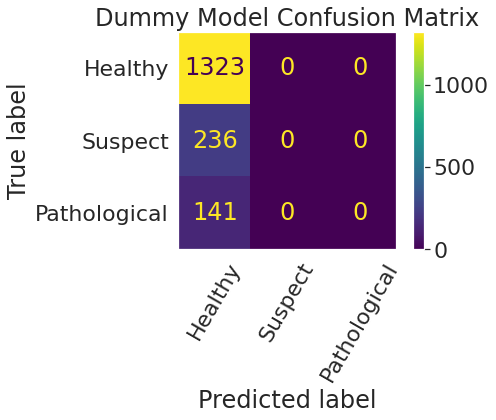

In [15]:
fig, ax = plt.subplots()

ConfusionMatrixDisplay.from_estimator(dummy_baseline,X_train,y_train,
    ax=ax
    #labels={1:'Healthy',2:'Suspect',3:'Pathological'}
    );

ax.set(
    yticklabels=['Healthy','Suspect','Pathological'],
    xticklabels=['Healthy','Suspect','Pathological'],
    title="Dummy Model Confusion Matrix"
);
plt.xticks(rotation=60)
ax.grid(False)

Visually, we can see that the 2 labels we care about are
entirely incorrectly predicted. We'll want to over-sample
our target values to improve our predictions on them.

We'll go ahead and start creating our initial models from
here.

## Initial Models

Throughout this process, we will be using SMOTE to
perform our over-sampling. We'll perform this process
within a pipeline and will 

## Approach 1: KNN

In [16]:
initial_knn_pipeline = imbPipeline(steps=[
    ('ss',StandardScaler()),

    ('o',SMOTE(random_state=1,sampling_strategy='auto')),

    ('knn',KNeighborsClassifier(n_neighbors=5, n_jobs=-2))
])

In [17]:
initial_knn_pipeline.fit(X_train,y_train)

Pipeline(steps=[('ss', StandardScaler()), ('o', SMOTE(random_state=1)),
                ('knn', KNeighborsClassifier(n_jobs=-2))])

(array([0, 1, 2]),
 [Text(0, 0, 'Normal'), Text(1, 0, 'Suspect'), Text(2, 0, 'Pathological')])

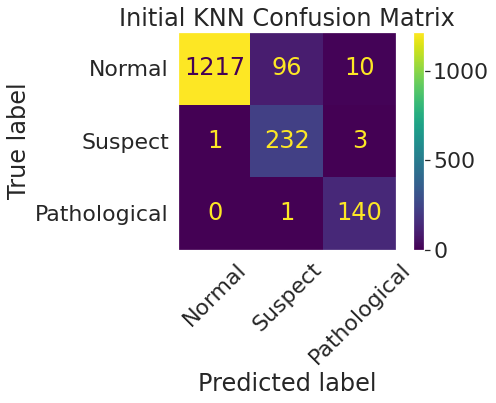

In [18]:
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_estimator(initial_knn_pipeline,X_train,y_train,
                        ax=ax);
ax.set(
    yticklabels=health_labels,
    xticklabels=health_labels,
    title="Initial KNN Confusion Matrix"
);
ax.grid(False)
plt.xticks(rotation=45)

(1700, 3)

Model recall:         0.9652792372040908
Median ROC AUC score: 0.9980725145473125
Cross Val Score:      0.8590297653030733
    


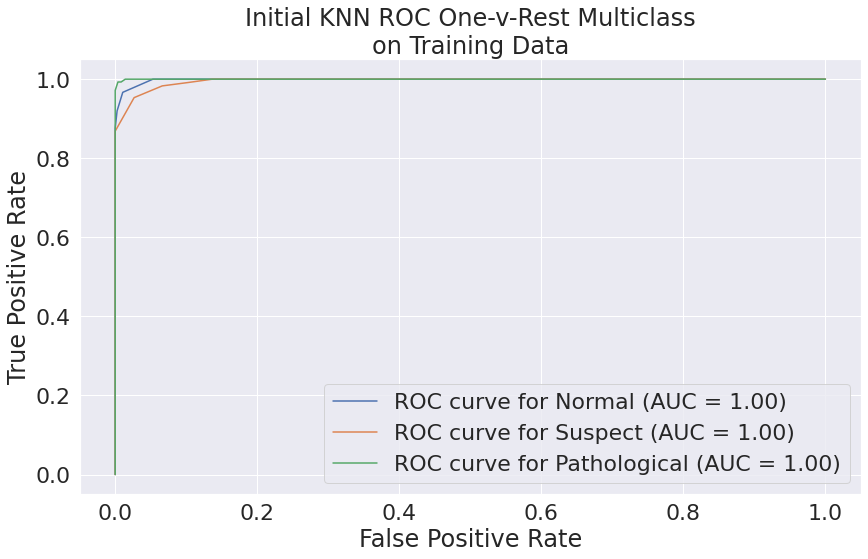

In [19]:
fig, ax = plt.subplots(figsize=(14,8))
knn_initial = model_scoring(initial_knn_pipeline,X_train,y_train,average='macro',
                        plot_curve=True, ax=ax,
                        class_names=health_labels)

ax.set(
    title="Initial KNN " + ax.title.get_text() + "\non Training Data"
)

'';

This model is showing 100% in all categories for its
predictions, which is... suspicious. It's very likely
that the model is extremely overfit - we'll go ahead
and run a grid search on this to see what all we can
do to tweak this model.

### Performing a grid search:

In [20]:
knn_params = {
    'o__sampling_strategy':['auto','all'],
    'knn__n_neighbors':[3,5,7],
    'knn__p':[1,2,3]
}

In [21]:
knn_gs = GridSearchCV(
    initial_knn_pipeline,
    param_grid=knn_params,
    n_jobs=-2,verbose=3
)

In [22]:
knn_gs.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('o', SMOTE(random_state=1)),
                                       ('knn',
                                        KNeighborsClassifier(n_jobs=-2))]),
             n_jobs=-2,
             param_grid={'knn__n_neighbors': [3, 5, 7], 'knn__p': [1, 2, 3],
                         'o__sampling_strategy': ['auto', 'all']},
             verbose=3)

In [23]:
knn_gs.best_params_ , knn_gs.best_estimator_ , knn_gs.best_score_

({'knn__n_neighbors': 3, 'knn__p': 1, 'o__sampling_strategy': 'auto'},
 Pipeline(steps=[('ss', StandardScaler()), ('o', SMOTE(random_state=1)),
                 ('knn', KNeighborsClassifier(n_jobs=-2, n_neighbors=3, p=1))]),
 0.8947058823529412)

(1700, 3)

Model recall:         0.9827173486696438
Median ROC AUC score: 0.9993629010696551
Cross Val Score:      0.8541974406864563
    


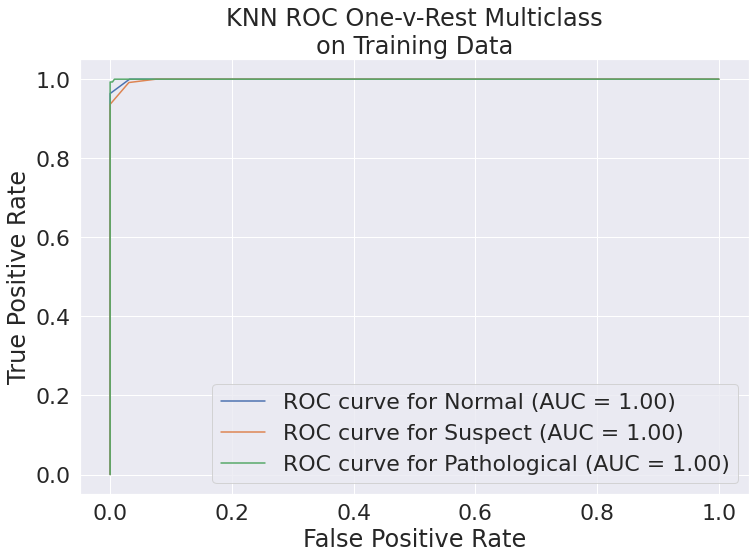

In [24]:
fig, ax = plt.subplots(figsize=(12,8))

best_knn_initial = model_scoring(
    knn_gs.best_estimator_,X_train,y_train,average='macro',
                        plot_curve=True, ax=ax,
                        class_names=health_labels)

ax.set(
    title="KNN " + ax.title.get_text() + "\non Training Data"
)

'';


This model is still showing an AUC of 1 on _**ALL**_
targets. Additionally, the cross val score is much 
lower. We are still likely over-fitting pretty
heavily. We'll want to take a look at the data a
little closer and see what data is impacting this the
most and try to simplify the model to use less features
as this should improve  generalization.

### Showing that the features are not generalizing well:

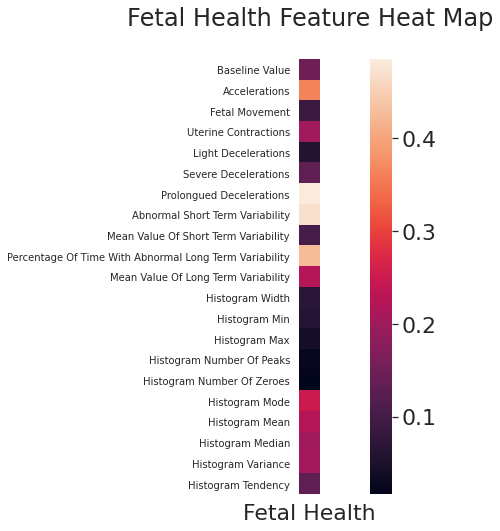

In [25]:
fig, ax = plt.subplots(figsize=(18,8))

sns.heatmap(np.abs(fetal_df.corr())[:-1][['fetal_health']],square=True,ax=ax,
yticklabels=True)

ax.yaxis.set_minor_locator(MaxNLocator(integer=True,nbins=len(clean_titles)-1))
ax.set_yticklabels(
    clean_titles[:-1],fontsize=10)
ax.set(
    title="Fetal Health Feature Heat Map\n",
    xticklabels=['Fetal Health']
)

'';

Here, we can see that there are a handful of features
that are effecting the target values

In [26]:
highest_effect = list((abs_corr_eff := np.abs(fetal_df.corr()[:-1]['fetal_health']).sort_values()).tail().index)
highest_effect, abs_corr_eff

(['histogram_mode',
  'accelerations',
  'percentage_of_time_with_abnormal_long_term_variability',
  'abnormal_short_term_variability',
  'prolongued_decelerations'],
 histogram_number_of_zeroes                                0.016682
 histogram_number_of_peaks                                 0.023666
 histogram_max                                             0.045265
 light_decelerations                                       0.058870
 histogram_min                                             0.063175
 histogram_width                                           0.068789
 fetal_movement                                            0.088010
 mean_value_of_short_term_variability                      0.103382
 severe_decelerations                                      0.131934
 histogram_tendency                                        0.131976
 baseline value                                            0.148151
 uterine_contractions                                      0.204894
 histogram_median

After extracting the 5 values with the highest 
influence on the data, we'll create a new model that
only takes these features into account when training.  
We'll create an X_test variable for use later as well.

In [27]:
X_train_top_features = X_train[highest_effect]
X_test_top_features  = X_test[highest_effect]
X_train_top_features.head()

,histogram_mode,accelerations,percentage_of_time_with_abnormal_long_term_variability,abnormal_short_term_variability,prolongued_decelerations
1391,148.0,0.000,9.0,58.0,0.0
926,126.0,0.000,4.0,27.0,0.0
111,137.0,0.005,0.0,34.0,0.0
1207,144.0,0.006,2.0,45.0,0.0
897,150.0,0.000,0.0,32.0,0.0


(array([0, 1, 2]),
 [Text(0, 0, 'Normal'), Text(1, 0, 'Suspect'), Text(2, 0, 'Pathological')])

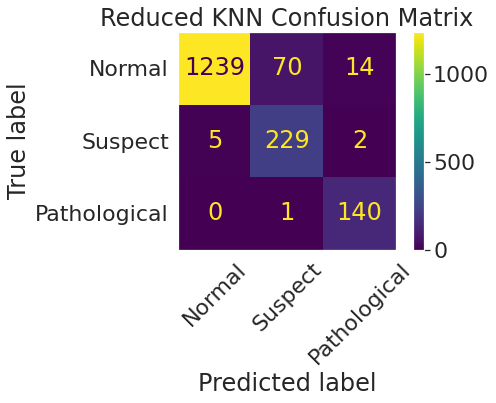

In [28]:
reduced_knn_pipeline = imbPipeline(steps=[
    ('ss',StandardScaler()),

    ('o',SMOTE(random_state=1,sampling_strategy='auto')),

    ('knn',KNeighborsClassifier(n_neighbors=5, n_jobs=-2))
])

reduced_knn_pipeline.fit(X_train_top_features,y_train)

fig, ax = plt.subplots()

ConfusionMatrixDisplay.from_estimator(
            reduced_knn_pipeline,X_train_top_features,y_train,
            ax=ax);

ax.set(
    title="Reduced KNN Confusion Matrix",
    yticklabels=health_labels,
    xticklabels=health_labels
)
ax.grid(False)

plt.xticks(rotation=45)

(1700, 3)

Model recall:         0.966584906992408
Median ROC AUC score: 0.9974224386560683
Cross Val Score:      0.8814828749972508
    


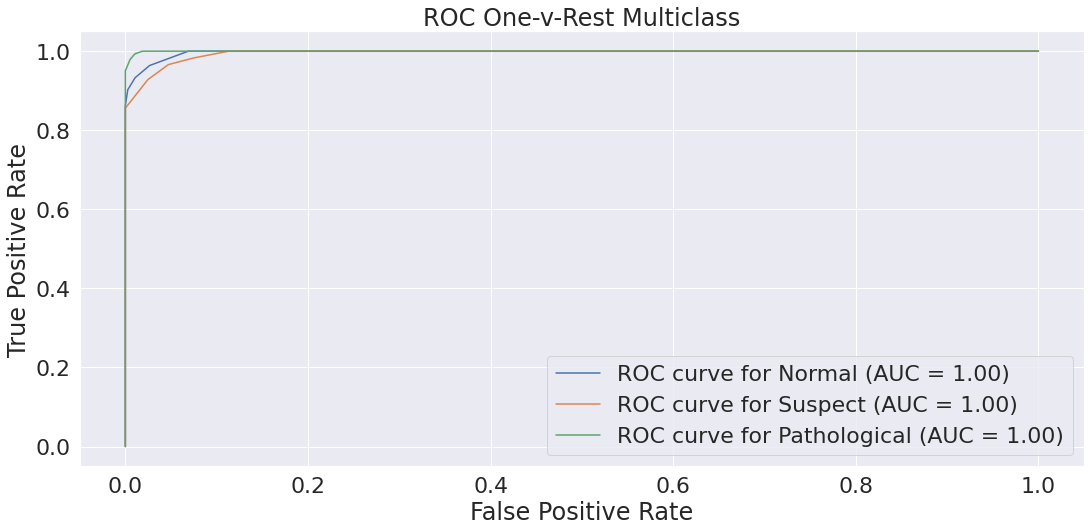

In [29]:
fig, ax = plt.subplots(figsize=(18,8))

reduced_knn_initial = model_scoring(
    reduced_knn_pipeline,X_train_top_features,y_train,average='macro',
                        plot_curve=True, ax=ax,
                        class_names=health_labels
    
)

In [30]:
reduced_knn_initial

{'recall': 0.966584906992408,
 'rocauc': 0.9974224386560683,
 'cv_score': array([0.87668559, 0.8652186 , 0.88445164, 0.87864151, 0.90241703]),
 'ax': <AxesSubplot:title={'center':'ROC One-v-Rest Multiclass'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>}

We'll use the same options as before to generate the
grid search, so we don't have to define new params. If
we detect the model picking edges, we can investigate
those params further.

In [31]:

knn_reduced_gs = GridSearchCV(
    reduced_knn_pipeline,
    param_grid=knn_params,
    n_jobs=-2,verbose=3
)

In [32]:
knn_reduced_gs.fit(X_train_top_features,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('o', SMOTE(random_state=1)),
                                       ('knn',
                                        KNeighborsClassifier(n_jobs=-2))]),
             n_jobs=-2,
             param_grid={'knn__n_neighbors': [3, 5, 7], 'knn__p': [1, 2, 3],
                         'o__sampling_strategy': ['auto', 'all']},
             verbose=3)

In [33]:
knn_reduced_gs.best_params_, knn_reduced_gs.best_estimator_, knn_reduced_gs.best_score_

({'knn__n_neighbors': 3, 'knn__p': 1, 'o__sampling_strategy': 'auto'},
 Pipeline(steps=[('ss', StandardScaler()), ('o', SMOTE(random_state=1)),
                 ('knn', KNeighborsClassifier(n_jobs=-2, n_neighbors=3, p=1))]),
 0.908235294117647)

(1700, 3)

Model recall:         0.9758078679909944
Median ROC AUC score: 0.9989318598805665
Cross Val Score:      0.8815450187026483
    


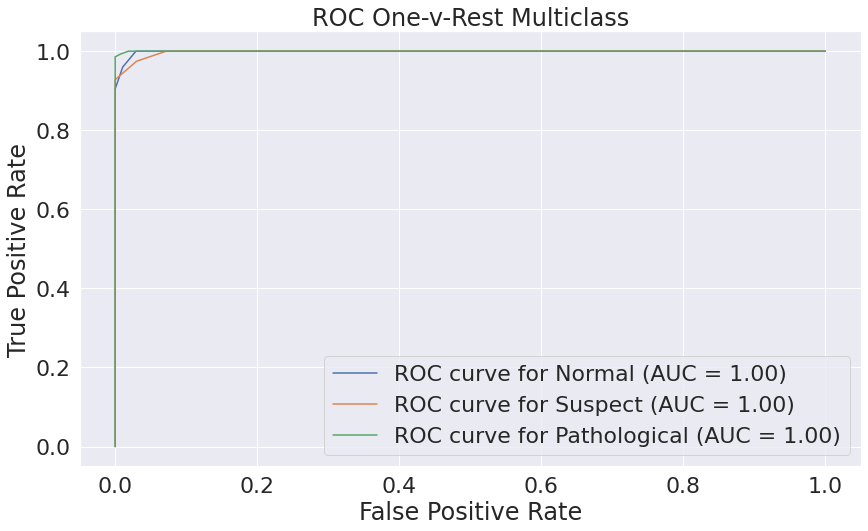

In [34]:
fig, ax = plt.subplots(figsize=(14,8))

best_knn_reduced = model_scoring(
    knn_reduced_gs.best_estimator_,
    X_train_top_features,y_train,average='macro',
    plot_curve=True,ax=ax,class_names=health_labels
)

## Investigating the Models

Now that we have a few models, we should put all of
their results into one place to really best understand
what exactly is happening with all of the scores.

In [35]:
display(Markdown(f"""
| Model | Recall | ROC AUC | CV Score |
|---:|:---:|:---:|:---:|
| KNN Initial |{
knn_initial['recall'] :.3f} | {
knn_initial['rocauc'] :.3f} | {
knn_initial['cv_score'].mean() :.3f} |
| Grid Searched Initial KNN | **{
best_knn_initial['recall'] :.3f}** | **{
best_knn_initial['rocauc'] :.3f}** | {
best_knn_initial['cv_score'].mean() :.3f}
| KNN Initial Reduced |{
reduced_knn_initial['recall'] :.3f} | {
reduced_knn_initial['rocauc'] :.3f} | {
reduced_knn_initial['cv_score'].mean() :.3f} | 
| Grid Searched KNN Reduced |{
best_knn_reduced['recall'] :.3f} | **{
best_knn_reduced['rocauc'] :.3f}** | **{
best_knn_reduced['cv_score'].mean() :.3f}** | """))


| Model | Recall | ROC AUC | CV Score |
|---:|:---:|:---:|:---:|
| KNN Initial |0.965 | 0.998 | 0.859 |
| Grid Searched Initial KNN | **0.983** | **0.999** | 0.854
| KNN Initial Reduced |0.967 | 0.997 | 0.881 | 
| Grid Searched KNN Reduced |0.976 | **0.999** | **0.882** | 

In [36]:
knn_reduced_gs.best_params_

{'knn__n_neighbors': 3, 'knn__p': 1, 'o__sampling_strategy': 'auto'}

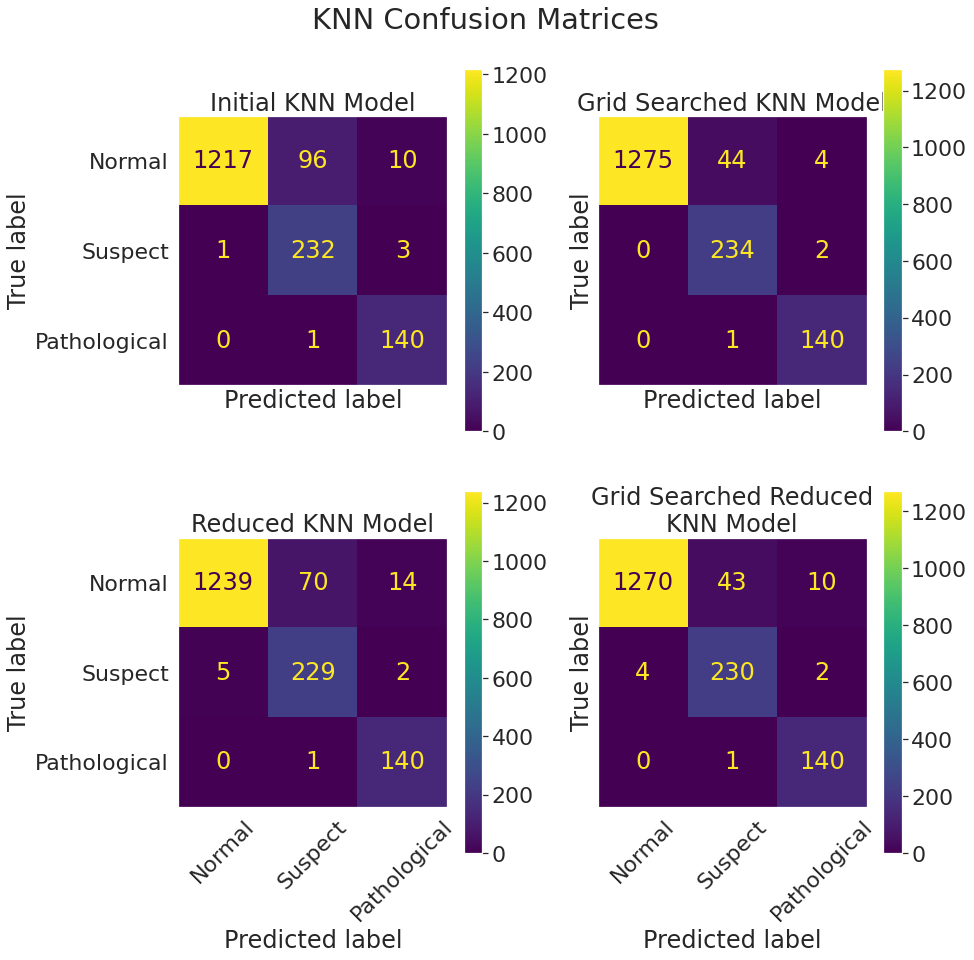

In [37]:
fig, ax = plt.subplots(2,2,figsize=(14,14),
                        sharey=True,sharex=True)

ConfusionMatrixDisplay.from_estimator(
            initial_knn_pipeline.fit(X_train,y_train),X_train,y_train,ax=ax[0,0])
ConfusionMatrixDisplay.from_estimator(
            knn_gs,X_train,y_train,ax=ax[0,1])
ConfusionMatrixDisplay.from_estimator(
            reduced_knn_pipeline.fit(X_train_top_features,y_train),X_train_top_features,y_train,ax=ax[1,0])
ConfusionMatrixDisplay.from_estimator(
            knn_reduced_gs,X_train_top_features,y_train,ax=ax[1,1])

ax[0,0].set(
    title='Initial KNN Model'
)
ax[0,1].set(
    title='Grid Searched KNN Model'
)
ax[1,0].set(
    title='Reduced KNN Model'
)
ax[1,1].set(
    title='Grid Searched Reduced\nKNN Model'
)

for ax_ in ax.flatten():
    ax_.grid(False)
    ax_.set(
        xticklabels=health_labels,
        yticklabels=health_labels
    )
    ax_.xaxis.set_tick_params(rotation=45)


fig.suptitle("KNN Confusion Matrices")

plt.tight_layout()
'';

These models are starting to take shape and look pretty
decent, but we want to make them as good of models as
we can. We'll take a look now at adding some features
to the grid search that was done above since the best
params include our lowest number of neighbors. We'll
look at the option of weighting based on distance in
lieu of keeping our neighbors so low.

In [38]:
knn_params_weighted = knn_params
knn_params_weighted['knn__weights'] = ['uniform','distance']

knn_reduced_gs_weighted = GridSearchCV(
    reduced_knn_pipeline,
    param_grid=knn_params_weighted,
    n_jobs=-2,verbose=3
)

In [39]:
knn_reduced_gs_weighted.fit(X_train_top_features,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('o', SMOTE(random_state=1)),
                                       ('knn',
                                        KNeighborsClassifier(n_jobs=-2))]),
             n_jobs=-2,
             param_grid={'knn__n_neighbors': [3, 5, 7], 'knn__p': [1, 2, 3],
                         'knn__weights': ['uniform', 'distance'],
                         'o__sampling_strategy': ['auto', 'all']},
             verbose=3)

In [40]:
knn_reduced_gs_weighted.best_params_

{'knn__n_neighbors': 3,
 'knn__p': 1,
 'knn__weights': 'distance',
 'o__sampling_strategy': 'auto'}

(1700, 3)

Model recall:         0.9957627118644069
Median ROC AUC score: 0.9999926511240845
Cross Val Score:      0.8804729572612573
    


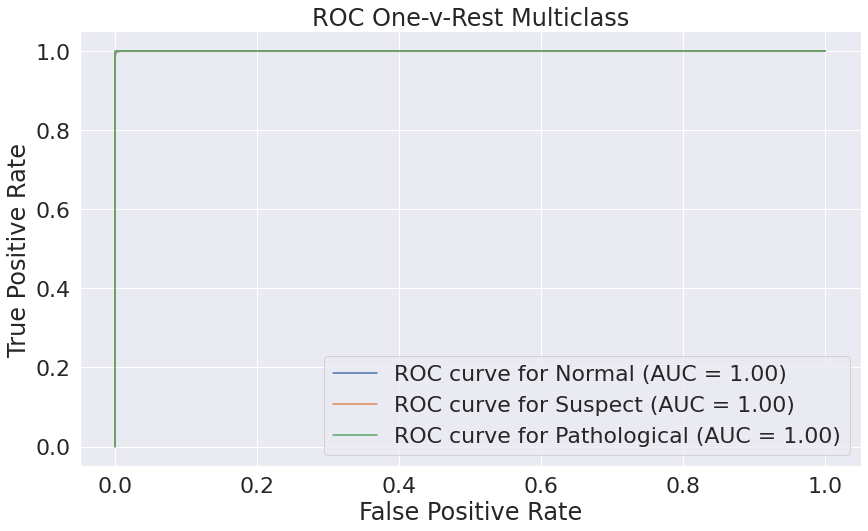

In [41]:
reduced_knn_gs_weighted = model_scoring(knn_reduced_gs_weighted.best_estimator_,
                X_train_top_features,y_train,
                average='macro',plot_curve=True,
                class_names=health_labels);

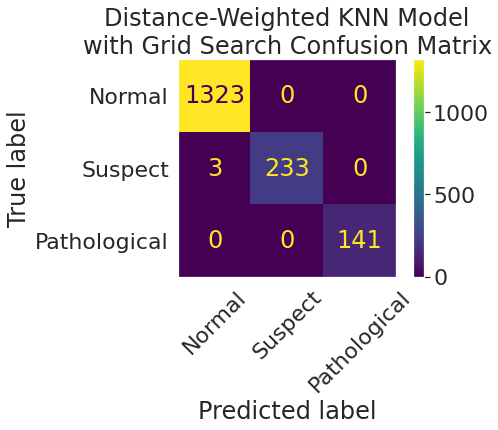

In [42]:
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_estimator(knn_reduced_gs_weighted,
                        X_train_top_features,y_train,ax=ax)

ax.set(
    title="Distance-Weighted KNN Model\nwith Grid Search Confusion Matrix",
    xticklabels=health_labels,
    yticklabels=health_labels
)
ax.grid(False)
plt.xticks(rotation=45)
'';

In [43]:
table_display = model_scoring_table(
    [
        best_knn_reduced,
        reduced_knn_gs_weighted
    ],[
        'Grid Searched KNN Reduced',
        'Distance-Weighted KNN Reduced'
        
    ]
)

display(table_display['md'])


| Model | Recall | ROC AUC | CV Score |
|---:|:---:|:---:|:---:|
| Grid Searched KNN Reduced |  0.976  |  0.999  | ***0.882*** |
| Distance-Weighted KNN Reduced | **0.996** | **1.000** |  0.880  |


The CV score for the previous model is still better
than the score for this model. It looks like this model
really only increased the overfit. We'll move on to the
next approach from here.

## Approach 2: Random Forest

### Creating the Initial Model

In [44]:
initial_tree_pipeline = imbPipeline(steps=[
    ('ss',StandardScaler()),

    ('o',SMOTE(random_state=1,sampling_strategy='auto')),

    ('rfc',RandomForestClassifier(random_state=1,
                max_depth=5, n_jobs=-2))
])

In [45]:
initial_tree_pipeline.fit(X_train,y_train)

Pipeline(steps=[('ss', StandardScaler()), ('o', SMOTE(random_state=1)),
                ('rfc',
                 RandomForestClassifier(max_depth=5, n_jobs=-2,
                                        random_state=1))])

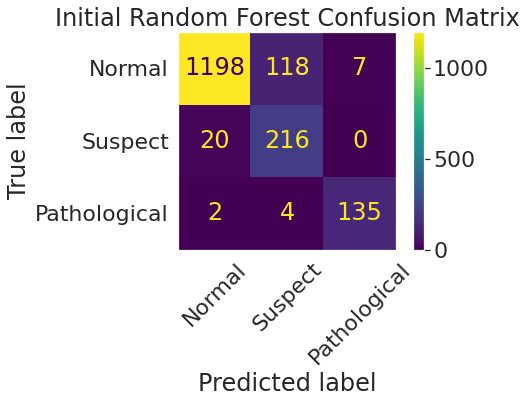

In [46]:
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_estimator(initial_tree_pipeline,X_train,y_train,
                        ax=ax);
ax.set(
    title="Initial Random Forest Confusion Matrix",
    xticklabels=health_labels,
    yticklabels=health_labels
)
ax.grid(False)
plt.xticks(rotation=45)
'';

(1700, 3)

Model recall:         0.9260729361531314
Median ROC AUC score: 0.9849576125520768
Cross Val Score:      0.8753076894604325
    


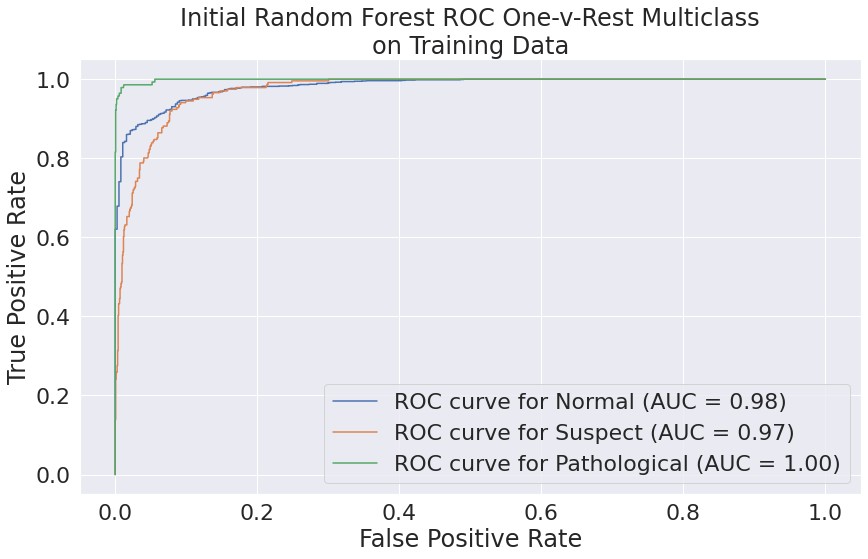

In [47]:
fig, ax = plt.subplots(figsize=(14,8))
tree_initial = model_scoring(initial_tree_pipeline,X_train,y_train,average='macro',
                        plot_curve=True, ax=ax,
                        class_names=health_labels)

ax.set(
    title="Initial Random Forest " + ax.title.get_text() + "\non Training Data"
)

'';

The initial model has a decent recall score at ~92.6% with
a median auc roc score of 98.5%  
As well, we already have a better CV score than our
previous models.


In [48]:
tree_params = {
    'o__sampling_strategy':['auto','all'],
    'rfc__max_depth': [3,5,7],
    'rfc__min_samples_split': [2,4,6]
}

In [49]:
tree_gs = GridSearchCV(
    initial_tree_pipeline,
    param_grid=tree_params,
    n_jobs=-2, verbose=3
)

In [50]:
tree_gs.fit(X_train,y_train)
tree_gs.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


{'o__sampling_strategy': 'auto',
 'rfc__max_depth': 7,
 'rfc__min_samples_split': 4}

(1700, 3)

Model recall:         0.9549041812234503
Median ROC AUC score: 0.9934588937750992
Cross Val Score:      0.9024917772848253
    


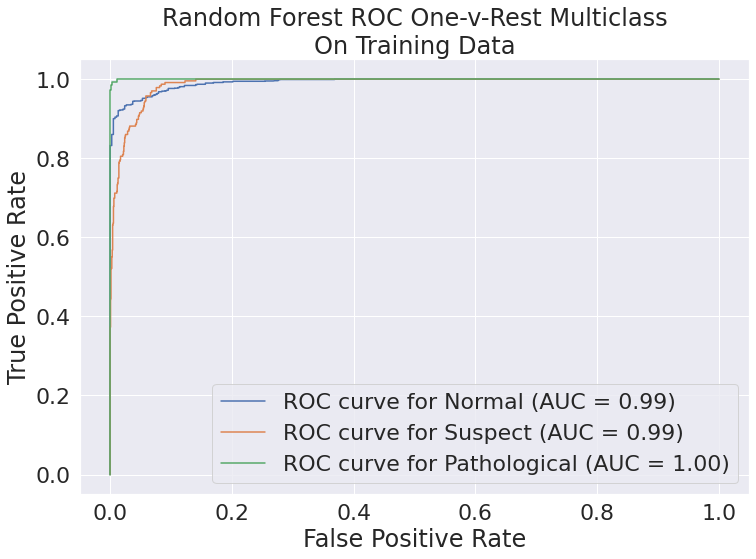

In [51]:
fig, ax = plt.subplots(figsize=(12,8))
best_tree_initial = model_scoring(
    tree_gs.best_estimator_,X_train,y_train,average='macro',
                        plot_curve=True, ax=ax,
                        class_names=health_labels)

ax.set(
    title="Random Forest " + ax.title.get_text() + "\nOn Training Data"
);

Just like before, we should have the tree take a look
at a smaller set of parameters. First, we'll have the
tree look at the same subset that our KNN model did to
get a good comparison between the classifications of
both.

In [52]:
reduced_tree_pipeline = imbPipeline(steps=[
    ('ss',StandardScaler()),

    ('o',SMOTE(random_state=1,sampling_strategy='auto')),

    ('rfc',RandomForestClassifier(random_state=1,
                max_depth=5, n_jobs=-2))
])
reduced_tree_pipeline.fit(X_train_top_features,y_train)

Pipeline(steps=[('ss', StandardScaler()), ('o', SMOTE(random_state=1)),
                ('rfc',
                 RandomForestClassifier(max_depth=5, n_jobs=-2,
                                        random_state=1))])

(1700, 3)

Model recall:         0.9190744361480885
Median ROC AUC score: 0.9808657978120546
Cross Val Score:      0.8930272971851274
    


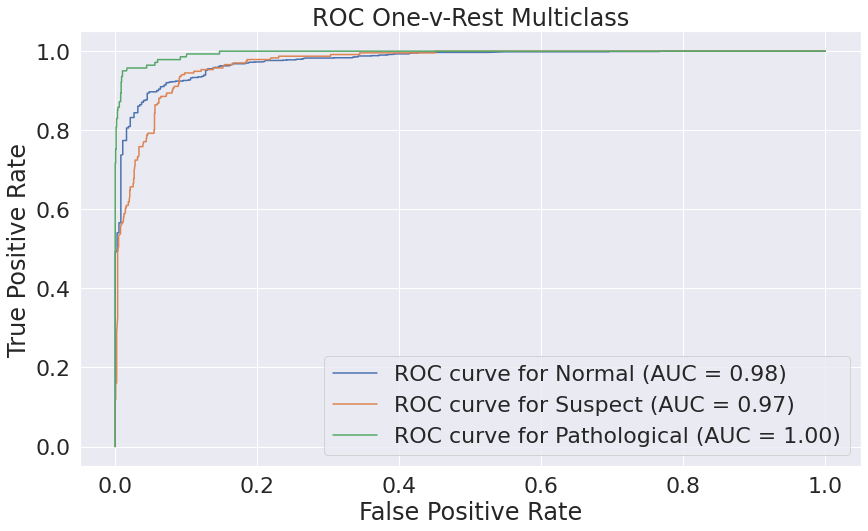

In [53]:
fig,ax = plt.subplots(figsize=(14,8))
reduced_tree_initial = model_scoring(
    reduced_tree_pipeline,
    X_train_top_features,y_train,
    average='macro',plot_curve=True,ax=ax,
    class_names=health_labels
)

It looks like the CV score actually went down when we
reduced the number of columns in the decision tree as
compared to our previous models. We'll go ahead and run
a grid search from this reduced set to see if there's a
good tweak that can be made to make the CV better.

In [54]:
reduced_tree_gs = GridSearchCV(
    reduced_tree_pipeline,
    param_grid=tree_params,
    n_jobs=-2, verbose=3)
reduced_tree_gs.fit(X_train_top_features,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('o', SMOTE(random_state=1)),
                                       ('rfc',
                                        RandomForestClassifier(max_depth=5,
                                                               n_jobs=-2,
                                                               random_state=1))]),
             n_jobs=-2,
             param_grid={'o__sampling_strategy': ['auto', 'all'],
                         'rfc__max_depth': [3, 5, 7],
                         'rfc__min_samples_split': [2, 4, 6]},
             verbose=3)

(1700, 3)

Model recall:         0.9461448067092633
Median ROC AUC score: 0.9902798704926536
Cross Val Score:      0.9024995469583919
    


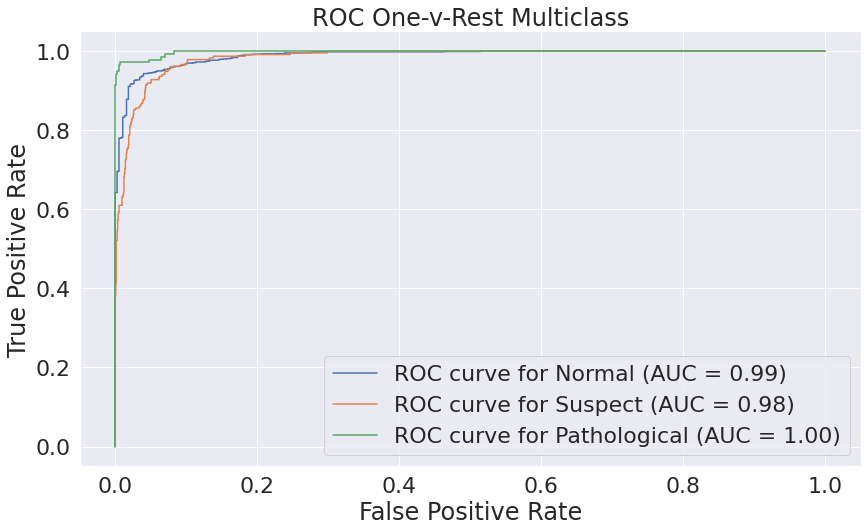

In [55]:
fig, ax = plt.subplots(figsize=(14,8))
best_tree_reduced = model_scoring(
    reduced_tree_gs.best_estimator_,
    X_train_top_features,y_train,
    average='macro',plot_curve=True,
    ax=ax, class_names=health_labels
)

And again, we'll compare the models.

In [56]:
display_table = model_scoring_table([
    tree_initial,
    best_tree_initial,
    reduced_tree_initial,
    best_tree_reduced
],[
    'Forest Initial',
    'Grid Searched Initial Forest',
    'Forest Initial Reduced',
    'Grid Searched Forest Reduced'
    ])
display(display_table['md'])


| Model | Recall | ROC AUC | CV Score |
|---:|:---:|:---:|:---:|
| Forest Initial |  0.926  |  0.985  |  0.875  |
| Grid Searched Initial Forest | **0.955** | **0.993** | ***0.902*** |
| Forest Initial Reduced |  0.919  |  0.981  |  0.893  |
| Grid Searched Forest Reduced |  0.946  |  0.990  | ***0.902*** |


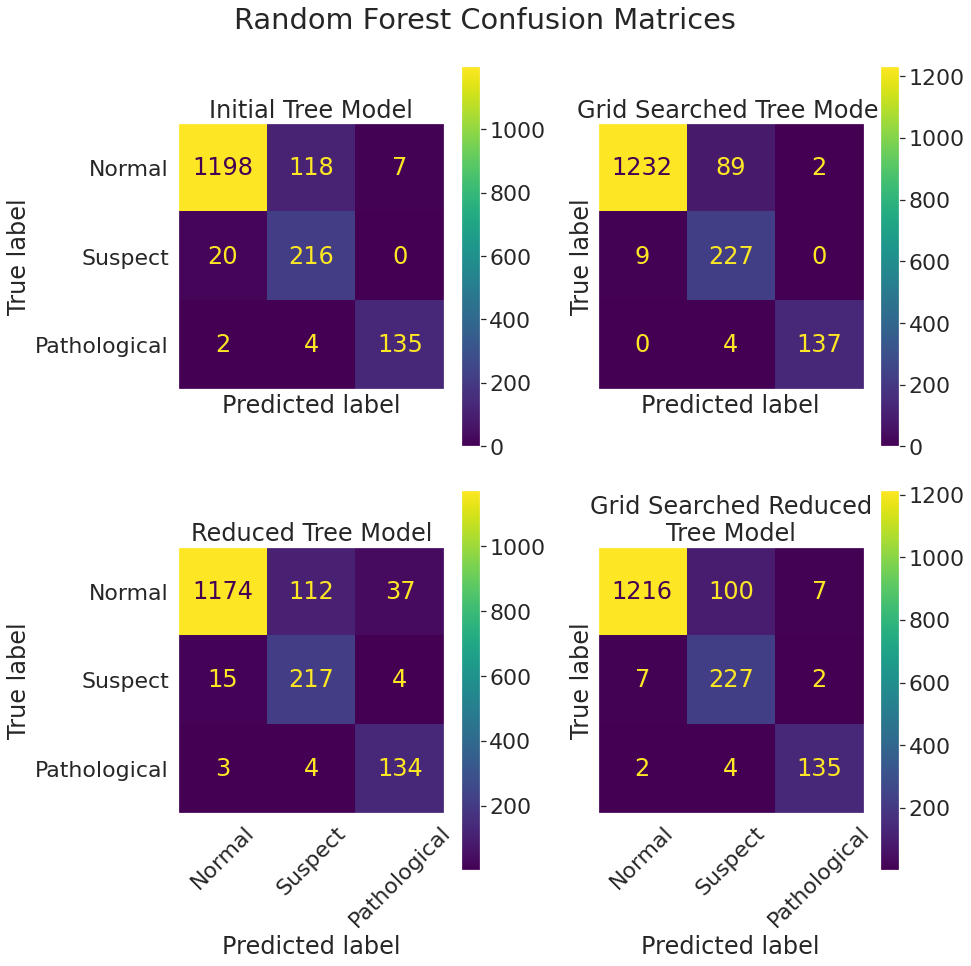

In [57]:
fig, ax = plt.subplots(2,2,figsize=(14,14),
                        sharex=True,sharey=True)

ConfusionMatrixDisplay.from_estimator(
            initial_tree_pipeline.fit(X_train,y_train),X_train,y_train,ax=ax[0,0])
ConfusionMatrixDisplay.from_estimator(
            tree_gs,X_train,y_train,ax=ax[0,1])
ConfusionMatrixDisplay.from_estimator(
            reduced_tree_pipeline.fit(X_train_top_features,y_train),X_train_top_features,y_train,ax=ax[1,0])
ConfusionMatrixDisplay.from_estimator(
            reduced_tree_gs,X_train_top_features,y_train,ax=ax[1,1])

ax[0,0].set(
    title='Initial Tree Model'
)
ax[0,1].set(
    title='Grid Searched Tree Model'
)
ax[1,0].set(
    title='Reduced Tree Model'
)
ax[1,1].set(
    title='Grid Searched Reduced\nTree Model'
)

for ax_ in ax.flatten():
    ax_.grid(False)
    ax_.set(
        xticklabels=health_labels,
        yticklabels=health_labels
    )
    ax_.xaxis.set_tick_params(rotation=45)


fig.suptitle("KNN Confusion Matrices")

plt.tight_layout()
'';

fig.suptitle("Random Forest Confusion Matrices")

plt.tight_layout()

In this case, model with all of the columns actually
performs the best. It seems that there are some 
determinations in some of the smaller variables that
are fairly important when going through the decision
trees that be influencing some of the results.

Let's go ahead and put the two best models together and
see how they compare.

In [58]:
score_table = model_scoring_table([best_knn_reduced,best_tree_initial],[
    'Grid Searched KNN Reduced',
    'Grid Searched Initial Forest'
])
display(score_table['md'])


| Model | Recall | ROC AUC | CV Score |
|---:|:---:|:---:|:---:|
| Grid Searched KNN Reduced | **0.976** | **0.999** |  0.882  |
| Grid Searched Initial Forest |  0.955  |  0.993  | ***0.902*** |


Additionally, we can try another Random Forest with a
different weight setting instead of trying a SMOTE
model.

In [59]:
balanced_tree_pipeline = imbPipeline(steps=[
    ('ss',StandardScaler()),

    ('rfc',RandomForestClassifier(random_state=1,
                max_depth=5, n_jobs=-2,
                class_weight='balanced'))
])

In [60]:
balanced_tree_pipeline.fit(X_train,y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('rfc',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        n_jobs=-2, random_state=1))])

(1700, 3)

Model recall:         0.9306211445591178
Median ROC AUC score: 0.9871731524270375
Cross Val Score:      0.8691070985367695
    


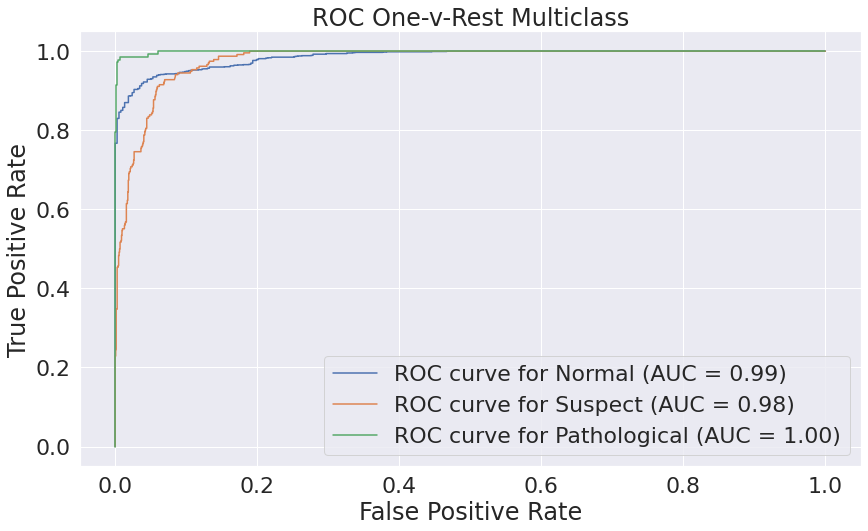

In [61]:
fig, ax = plt.subplots(figsize=(14,8))
balanced_tree = model_scoring(balanced_tree_pipeline,X_train,y_train,
            plot_curve=True,ax=ax, class_names=health_labels,
            average='macro')
'';

This model looks to have a lower CV score, but we can
take the same thought process through a grid search.

In [62]:
balanced_tree_params = {
    'rfc__max_depth': [3,5,7,9,11],
    'rfc__min_samples_split':[2,4,6],
    'rfc__min_samples_leaf': [1,3,5],
    'rfc__min_samples_split': [2,4,6]
}
tree_weights_gs = GridSearchCV(
    balanced_tree_pipeline,
    param_grid=balanced_tree_params,
    n_jobs=-2, verbose=3)
tree_weights_gs.fit(X_train,y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('rfc',
                                        RandomForestClassifier(class_weight='balanced',
                                                               max_depth=5,
                                                               n_jobs=-2,
                                                               random_state=1))]),
             n_jobs=-2,
             param_grid={'rfc__max_depth': [3, 5, 7, 9, 11],
                         'rfc__min_samples_leaf': [1, 3, 5],
                         'rfc__min_samples_split': [2, 4, 6]},
             verbose=3)

In [63]:
tree_weights_gs.best_params_ , tree_weights_gs.best_estimator_ , tree_weights_gs.best_score_

({'rfc__max_depth': 11,
  'rfc__min_samples_leaf': 1,
  'rfc__min_samples_split': 4},
 Pipeline(steps=[('ss', StandardScaler()),
                 ('rfc',
                  RandomForestClassifier(class_weight='balanced', max_depth=11,
                                         min_samples_split=4, n_jobs=-2,
                                         random_state=1))]),
 0.9364705882352939)

(1700, 3)

Model recall:         0.9919403096682302
Median ROC AUC score: 0.9994751683429844
Cross Val Score:      0.885712898174484
    


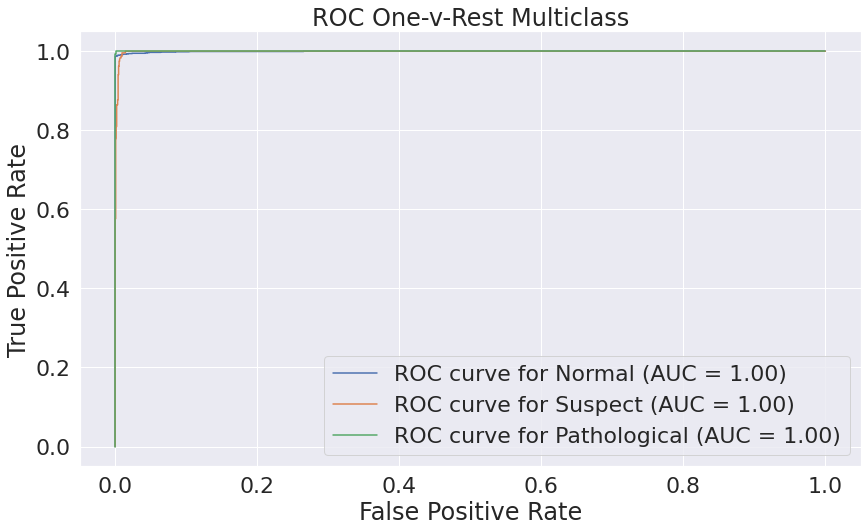

In [64]:
fig, ax = plt.subplots(figsize=(14,8))
scores_balanced_tree = model_scoring(
    tree_weights_gs.best_estimator_,
    X_train,y_train,ax=ax,average='macro',
    plot_curve=True,class_names=health_labels
)
'';

In [65]:
Markdown(f"""
| Model | Recall | ROC AUC | CV Score |
|---:|:---:|:---:|:---:|
| Grid Searched KNN Reduced | {
best_knn_reduced['recall'] :.3f} | **{
best_knn_reduced['rocauc'] :.3f}** | {
best_knn_reduced['cv_score'].mean() :.3f} |
| Grid Searched Initial Forest | {
best_tree_initial['recall'] :.3f} | {
best_tree_initial['rocauc'] :.3f} | **{
best_tree_initial['cv_score'].mean() :.3f}** |
| Grid Searched Balanced Forest | **{
scores_balanced_tree['recall'] :.3f}** | **{
scores_balanced_tree['rocauc'] :.3f}** | {
scores_balanced_tree['cv_score'].mean() :.3f} |""")


| Model | Recall | ROC AUC | CV Score |
|---:|:---:|:---:|:---:|
| Grid Searched KNN Reduced | 0.976 | **0.999** | 0.882 |
| Grid Searched Initial Forest | 0.955 | 0.993 | **0.902** |
| Grid Searched Balanced Forest | **0.992** | **0.999** | 0.886 |

According to our CV score, our best model is our
initial grid searched random forest with a CV score of
0.902.

Fitting 5 folds for each of 36 candidates, totalling 180 fits


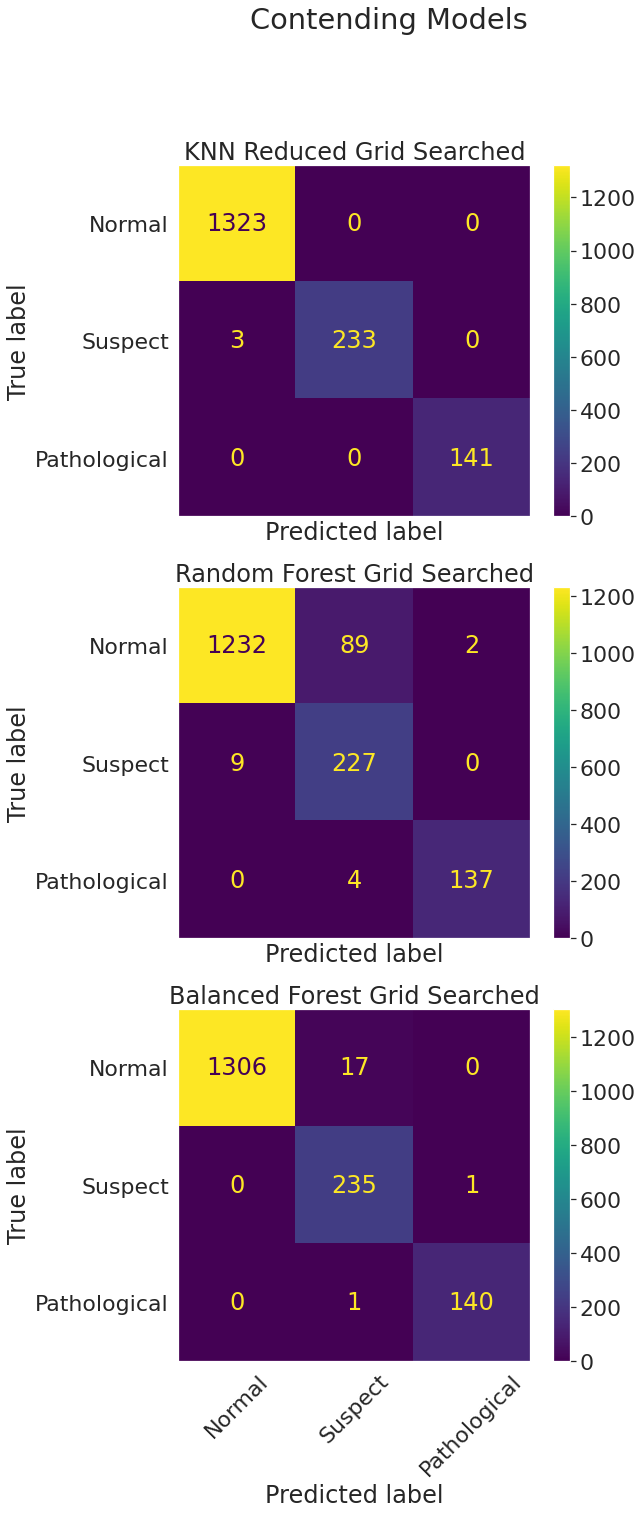

In [66]:
fig, ax = plt.subplots(3,1,figsize=(8,22),sharex=True)
ConfusionMatrixDisplay.from_estimator(
    knn_reduced_gs.fit(X_train_top_features,y_train),X_train_top_features,y_train,
    ax=ax[0])
ConfusionMatrixDisplay.from_estimator(
    tree_gs,X_train,y_train,
    ax=ax[1])
ConfusionMatrixDisplay.from_estimator(
    tree_weights_gs,X_train,y_train,
    ax=ax[2])
for ax_ in ax:
    ax_.grid(False)
    ax_.set(
        xticklabels=health_labels,
        yticklabels=health_labels
    )
plt.xticks(rotation=45)

ax[0].set(
    title="KNN Reduced Grid Searched"
)
ax[1].set(
    title="Random Forest Grid Searched"
)
ax[2].set(
    title="Balanced Forest Grid Searched"
)
plt.suptitle("Contending Models")
'';

As of yet, the grid searched random forest with all
features and SMOTE is our best model. We'll try one
more model with all of our features accounted for, but
there is a pattern coming up that might be worth
investigating. Many of our incorrect pathological and
suspect guesses are still falling within either the
suspect or pathological categories.  
Ideally, we would be able to categorize these
effectively 100% of the time, but any situation that is
at least in the suspect category would indicate a need
for additional tests to be run. If an Extra Random
Forest Classifier isn't able to get our data to produce
a higher CV score, we'll want to take a look at our
current models against a binarized version of our
target column.

## Approach 2.5: Extra Trees

Because the Extra Trees process is extremely similar to
the Random Forest classifier with mostly the same
parameters, we're going to go ahead and run all of the
same tests in line and look at all of the results at
the end.

In [67]:
extra_tree_pipeline = imbPipeline(steps=[
    ('ss',StandardScaler()),

    ('o',SMOTE(random_state=1,sampling_strategy='auto')),

    ('etc',ExtraTreesClassifier(random_state=1,
                max_depth=5, n_jobs=-2))
])

balanced_extra_tree_pipeline = imbPipeline(steps=[
    ('ss',StandardScaler()),

    ('etc',ExtraTreesClassifier(random_state=1,
                max_depth=5, n_jobs=-2,
                class_weight='balanced'))
])

extra_tree_pipeline.fit(X_train,y_train)
balanced_extra_tree_pipeline.fit(X_train,y_train)


Pipeline(steps=[('ss', StandardScaler()),
                ('etc',
                 ExtraTreesClassifier(class_weight='balanced', max_depth=5,
                                      n_jobs=-2, random_state=1))])

In [68]:
extra_tree_params = {
    'o__sampling_strategy':['auto','all'],
    'etc__max_depth': [3,5,7],
    'etc__min_samples_split': [2,4,6],
    'etc__min_samples_leaf': [1,3,5],
}

extra_tree_pipeline_gs          = GridSearchCV(
    extra_tree_pipeline,
    param_grid=extra_tree_params,
    n_jobs=-2, verbose=3)

balanced_extra_tree_params      = {
    'etc__max_depth': [3,5,7,9,11],
    'etc__min_samples_split':[2,4,6],
    'etc__min_samples_leaf': [1,3,5]
}
balanced_extra_tree_pipeline_gs = GridSearchCV(
    balanced_extra_tree_pipeline,
    param_grid=balanced_extra_tree_params,
    n_jobs=-2, verbose=3)

extra_tree_pipeline_gs.fit(X_train,y_train)
balanced_extra_tree_pipeline_gs.fit(X_train,y_train)
extra_tree_pipeline.fit(X_train,y_train)
balanced_extra_tree_pipeline.fit(X_train,y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 45 candidates, totalling 225 fits


Pipeline(steps=[('ss', StandardScaler()),
                ('etc',
                 ExtraTreesClassifier(class_weight='balanced', max_depth=5,
                                      n_jobs=-2, random_state=1))])

(1700, 3)

Model recall:         0.8635273759301373
Median ROC AUC score: 0.9699797573852486
Cross Val Score:      0.8495924514698654
    
(1700, 3)

Model recall:         0.8649801240900789
Median ROC AUC score: 0.9719116370252658
Cross Val Score:      0.8467295950049726
    
(1700, 3)
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits

Model recall:         0.901295125575173
Median ROC AUC score: 0.9837712317443791
Cross Val Score:      0.8634134509351842
    
(1700, 3)
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Fitting 5 folds 

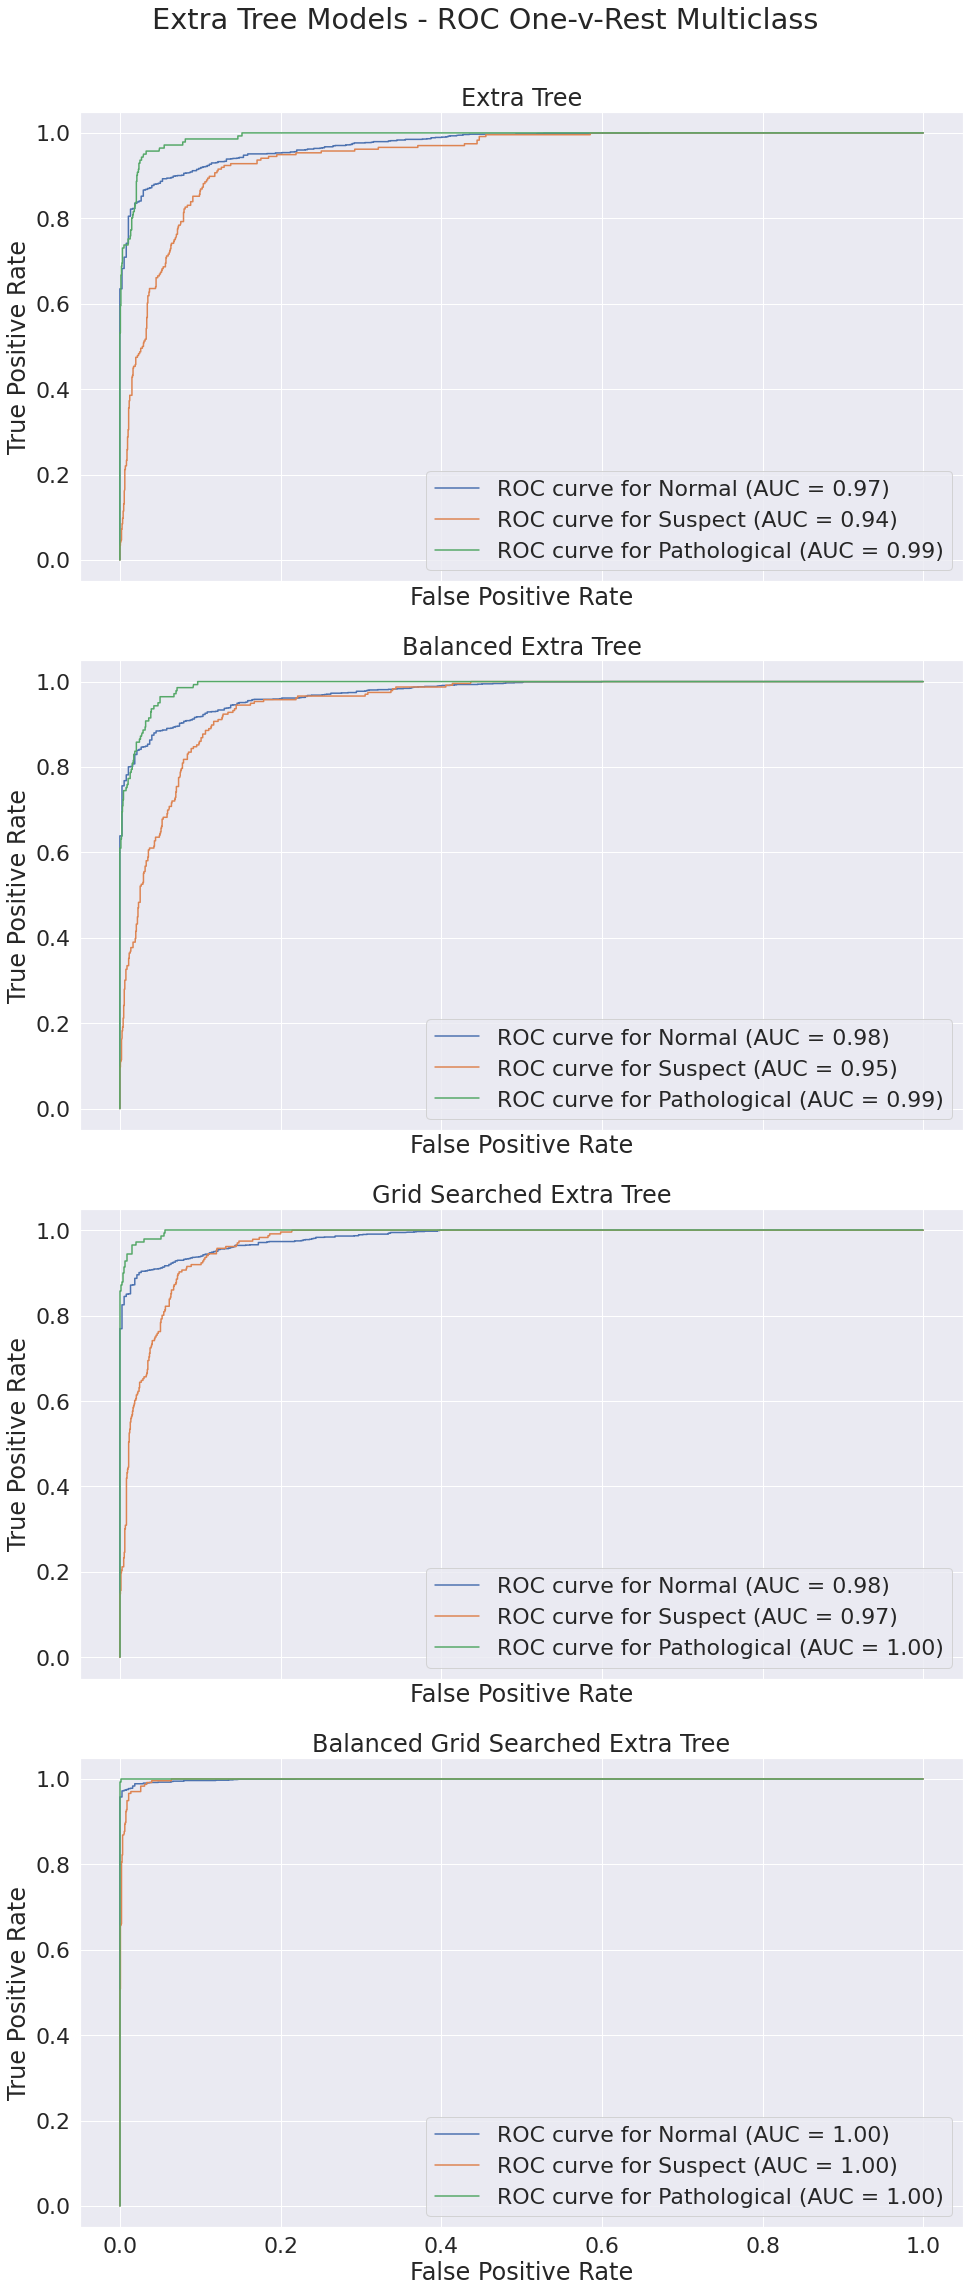

In [69]:
fig, ax = plt.subplots(4,1,figsize=(14,32),sharex=True)
scores_extra_tree = model_scoring(extra_tree_pipeline,X_train,y_train,
            plot_curve=True,ax=ax[0], class_names=health_labels,
            average='macro')
scores_balanced_extra_tree = model_scoring(balanced_extra_tree_pipeline,X_train,y_train,
            plot_curve=True,ax=ax[1], class_names=health_labels,
            average='macro')
scores_extra_tree_gs = model_scoring(extra_tree_pipeline_gs,X_train,y_train,
            plot_curve=True,ax=ax[2], class_names=health_labels,
            average='macro')
scores_balanced_extra_tree_gs = model_scoring(balanced_extra_tree_pipeline_gs,X_train,y_train,
            plot_curve=True,ax=ax[3], class_names=health_labels,
            average='macro')


ax[0].set(
    title="Extra Tree"
)
ax[1].set(
    title="Balanced Extra Tree"
)
ax[2].set(
    title="Grid Searched Extra Tree"
)
ax[3].set(
    title="Balanced Grid Searched Extra Tree"
)
fig.suptitle("Extra Tree Models - ROC One-v-Rest Multiclass",y=1)
plt.tight_layout()
'';

In [70]:
display_table = model_scoring_table([
    scores_extra_tree,
    scores_balanced_extra_tree,
    scores_extra_tree_gs,
    scores_balanced_extra_tree_gs
    ],[
        'Extra Tree',
        'Balanced Extra Tree',
        'Grid Searched Extra Tree',
        'Balanced Grid Searched Extra Tree',

    ]
)
display(display_table['md'])


| Model | Recall | ROC AUC | CV Score |
|---:|:---:|:---:|:---:|
| Extra Tree |  0.864  |  0.970  |  0.850  |
| Balanced Extra Tree |  0.865  |  0.972  |  0.847  |
| Grid Searched Extra Tree |  0.901  |  0.984  |  0.863  |
| Balanced Grid Searched Extra Tree | **0.980** | **0.999** | ***0.864*** |


It looks like our Extra Tree Classifier is giving us an
even worse CV score at this point.  
Something I was alluding to before, the main item we're
concerned about is Healthy vs Suspect _or worse_.

For the next section, we're going to translate the data
so that any values that would indicate that something
_might_ be wrong will be counted the same as those in
which something _is_ wrong. From there, we'll run the
same types of validation and come back to our current
models for comparison.

## Option 2: Reducing the Dataset at Large

Here we'll create a new set of `y_train` and `y_test`
to run our models on. Once we do this, our testing will
be mostly the same.

First, we'll verify shapes, etc.

In [71]:
y_train.value_counts() , y_train.shape, \
    '', \
(y_train_bin := y_train.map({1:0,2:1,3:1})).value_counts(), \
y_train_bin.shape

(1.0    1323
 2.0     236
 3.0     141
 Name: fetal_health, dtype: int64,
 (1700,),
 '',
 0    1323
 1     377
 Name: fetal_health, dtype: int64,
 (1700,))

In [72]:
y_test.value_counts() , y_test.shape, \
    '', \
(y_test_bin := y_test.map({1:0,2:1,3:1})).value_counts(), \
y_test_bin.shape

(1.0    332
 2.0     59
 3.0     35
 Name: fetal_health, dtype: int64,
 (426,),
 '',
 0    332
 1     94
 Name: fetal_health, dtype: int64,
 (426,))

Here, we'll go ahead and create translated versions of
all of the models from before to better fit the
binarized data.

In [73]:
binary_knn_pipeline = imbPipeline(steps=[
    ('ss',StandardScaler()),

    ('o',SMOTE(random_state=1,sampling_strategy='auto')),

    ('knn',KNeighborsClassifier(n_neighbors=5, n_jobs=-2))
])
binary_knn_pipeline.fit(X_train,y_train_bin)
reduced_binary_knn_pipeline = imbPipeline(steps=[
    ('ss',StandardScaler()),

    ('o',SMOTE(random_state=1,sampling_strategy='auto')),

    ('knn',KNeighborsClassifier(n_neighbors=5, n_jobs=-2))
])
reduced_binary_knn_pipeline.fit(X_train_top_features,y_train_bin)

binary_tree_pipeline = imbPipeline(steps=[
    ('ss',StandardScaler()),

    ('o',SMOTE(random_state=1,sampling_strategy='auto')),

    ('rfc',RandomForestClassifier(random_state=1,
                max_depth=5, n_jobs=-2))
])
binary_tree_pipeline.fit(X_train,y_train_bin)

binary_extra_tree_pipeline = imbPipeline(steps=[
    ('ss',StandardScaler()),

    ('o',SMOTE(random_state=1,sampling_strategy='auto')),

    ('etc',ExtraTreesClassifier(random_state=1,
                max_depth=5, n_jobs=-2))
])
binary_extra_tree_pipeline.fit(X_train,y_train_bin)

Pipeline(steps=[('ss', StandardScaler()), ('o', SMOTE(random_state=1)),
                ('etc',
                 ExtraTreesClassifier(max_depth=5, n_jobs=-2, random_state=1))])

In [104]:
##! DEFINE PARAMS HERE
binary_knn_params = {
    'o__sampling_strategy':['auto',0.8,0.6,0.4],
    'knn__n_neighbors':[3,5,7],
    'knn__p':[1,2,3]
}

binary_tree_params = {
    'o__sampling_strategy':['auto',0.8,0.6,0.4],
    'rfc__max_depth': [3,5,7,9,11],
    'rfc__min_samples_split': [2,4,6]
}

binary_extra_tree_params = {
    'o__sampling_strategy':['auto',0.8,0.6,0.4],
    'etc__max_depth': [3,5,7,9,11],
    'etc__min_samples_split': [2,4,6]
}

In [105]:
binary_knn_pipeline_gs = GridSearchCV(
    binary_knn_pipeline,
    param_grid=binary_knn_params,
    n_jobs=-2,verbose=3
)
reduced_binary_knn_pipeline_gs = GridSearchCV(
    reduced_binary_knn_pipeline,
    param_grid=binary_knn_params,
    n_jobs=-2,verbose=3
)
binary_tree_pipeline_gs = GridSearchCV(
    binary_tree_pipeline,
    param_grid=binary_tree_params,
    n_jobs=-2,verbose=3
)
binary_extra_tree_pipeline_gs = GridSearchCV(
    binary_extra_tree_pipeline,
    param_grid=binary_extra_tree_params,
    n_jobs=-2,verbose=3
)


In [106]:
binary_knn_pipeline_gs.fit(X_train,y_train_bin)
reduced_binary_knn_pipeline_gs.fit(X_train_top_features,y_train_bin)
binary_tree_pipeline_gs.fit(X_train,y_train_bin)
binary_extra_tree_pipeline_gs.fit(X_train,y_train_bin)
'';

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits



Model recall:         0.97767412299432
Median ROC AUC score: 0.9978136258924436
Cross Val Score:      0.8982667388883876
    

Model recall:         0.9598904106293269
Median ROC AUC score: 0.9932995302453431
Cross Val Score:      0.9177457795431977
    

Model recall:         0.9878782046269731
Median ROC AUC score: 0.9996872312143248
Cross Val Score:      0.9254230236827059
    

Model recall:         0.9822092703866103
Median ROC AUC score: 0.9984882842025699
Cross Val Score:      0.911230477566128
    


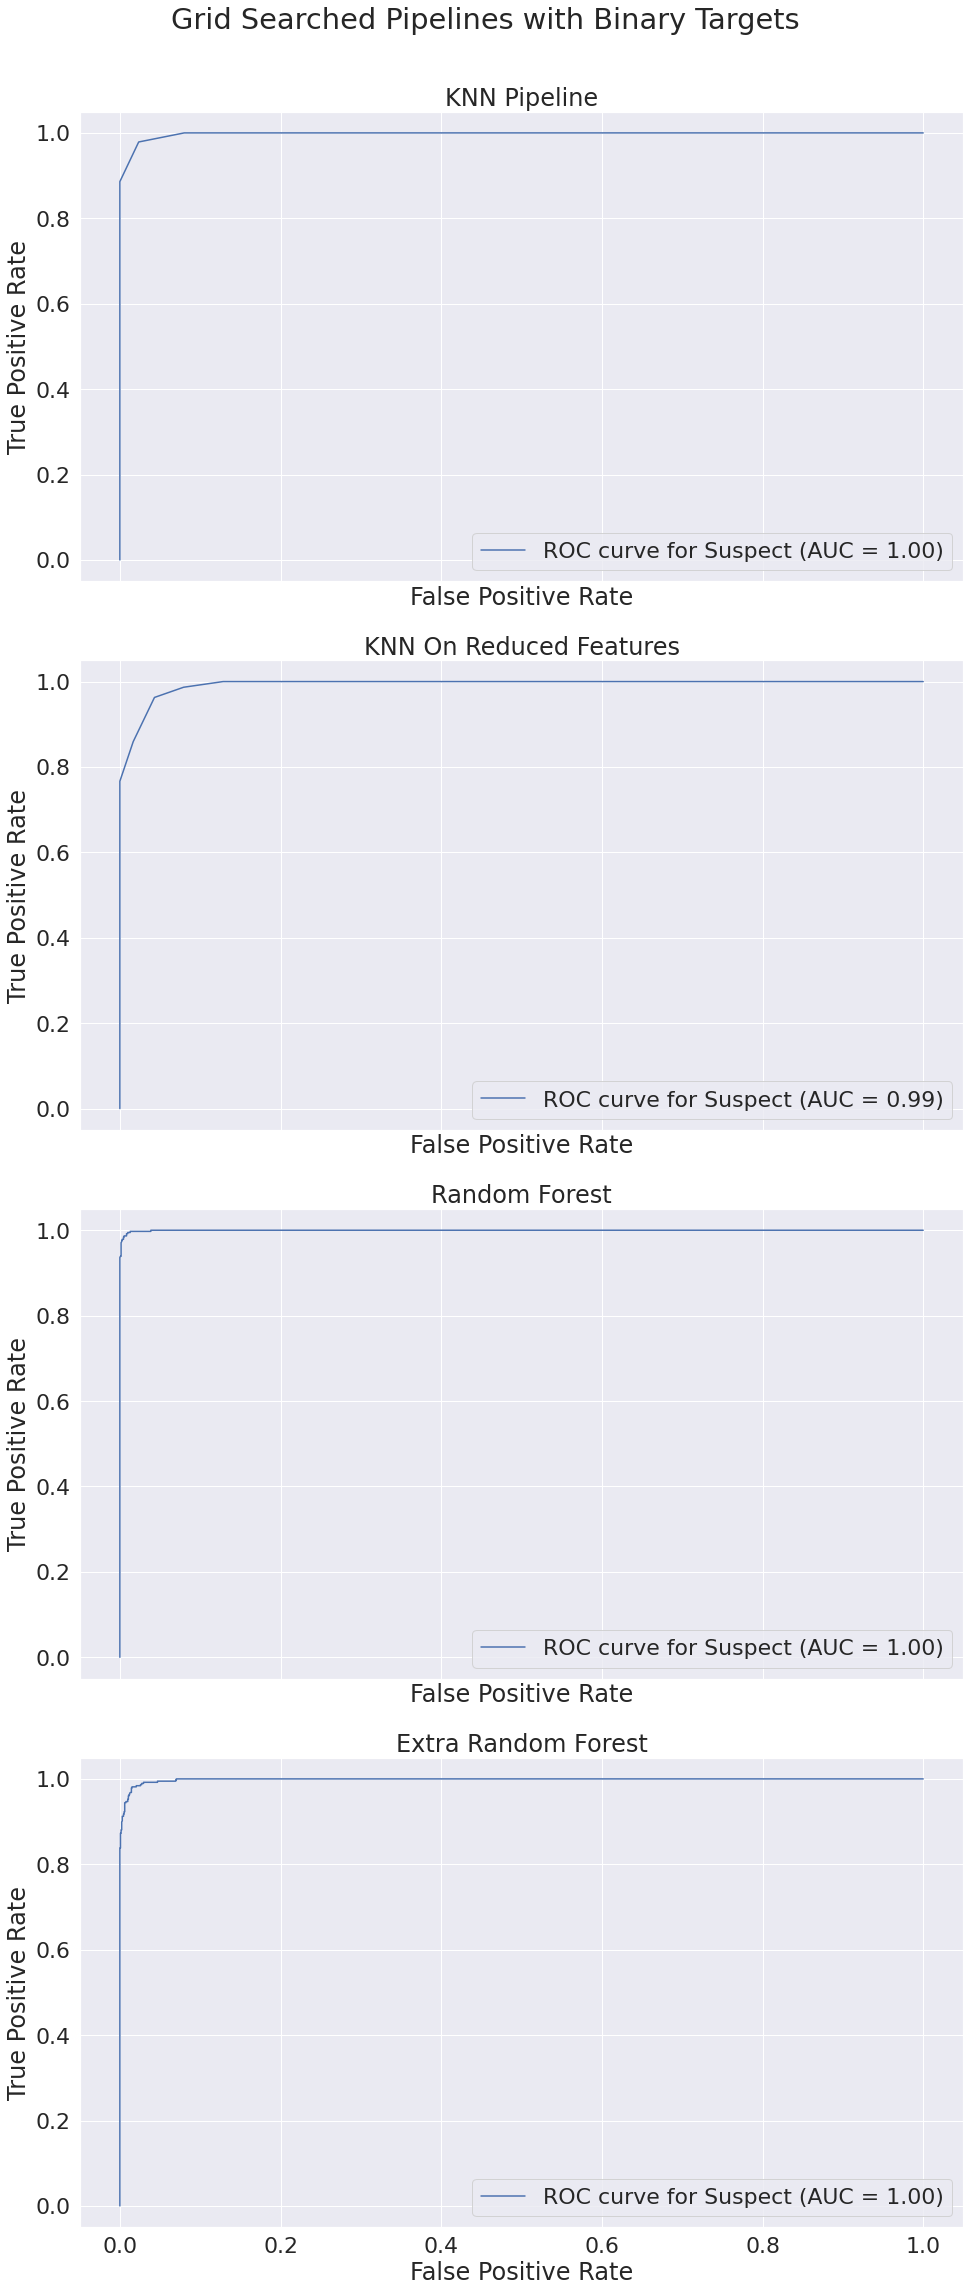

In [107]:
fig, ax = plt.subplots(4,1,figsize=(14,32),sharex=True)
scores_binary_knn_pipeline_gs = model_scoring(
            binary_knn_pipeline_gs.best_estimator_,
            X_train,y_train_bin,
            plot_curve=True,ax=ax[0], class_names=health_labels,
            average='macro',multi_class='raise',
            is_binary=True)
scores_reduced_binary_knn_pipeline_gs = model_scoring(
            reduced_binary_knn_pipeline_gs.best_estimator_,
            X_train_top_features,y_train_bin,
            plot_curve=True,ax=ax[1], class_names=health_labels,
            average='macro',multi_class='raise',
            is_binary=True)
scores_binary_tree_pipeline_gs = model_scoring(
            binary_tree_pipeline_gs.best_estimator_,
            X_train,y_train_bin,
            plot_curve=True,ax=ax[2], class_names=health_labels,
            average='macro',multi_class='raise',
            is_binary=True)
scores_binary_extra_tree_pipeline_gs = model_scoring(
            binary_extra_tree_pipeline_gs.best_estimator_,
            X_train,y_train_bin,
            plot_curve=True,ax=ax[3], class_names=health_labels,
            average='macro',multi_class='raise',
            is_binary=True)


ax[0].set(
    title="KNN Pipeline"
)
ax[1].set(
    title="KNN On Reduced Features"
)
ax[2].set(
    title="Random Forest"
)
ax[3].set(
    title="Extra Random Forest"
)
fig.suptitle("Grid Searched Pipelines with Binary Targets",y=1)
plt.tight_layout()
'';


| Model | Recall | ROC AUC | CV Score |
|---:|:---:|:---:|:---:|
| Binary KNN Pipeline |  0.978  |  0.998  |  0.898  |
| Binary Reduced KNN Pipeline |  0.960  |  0.993  |  0.918  |
| Binary Random Forest Pipeline | **0.988** | **1.000** | ***0.925*** |
| Binary Extra Random Forest Pipeline |  0.982  |  0.998  |  0.911  |


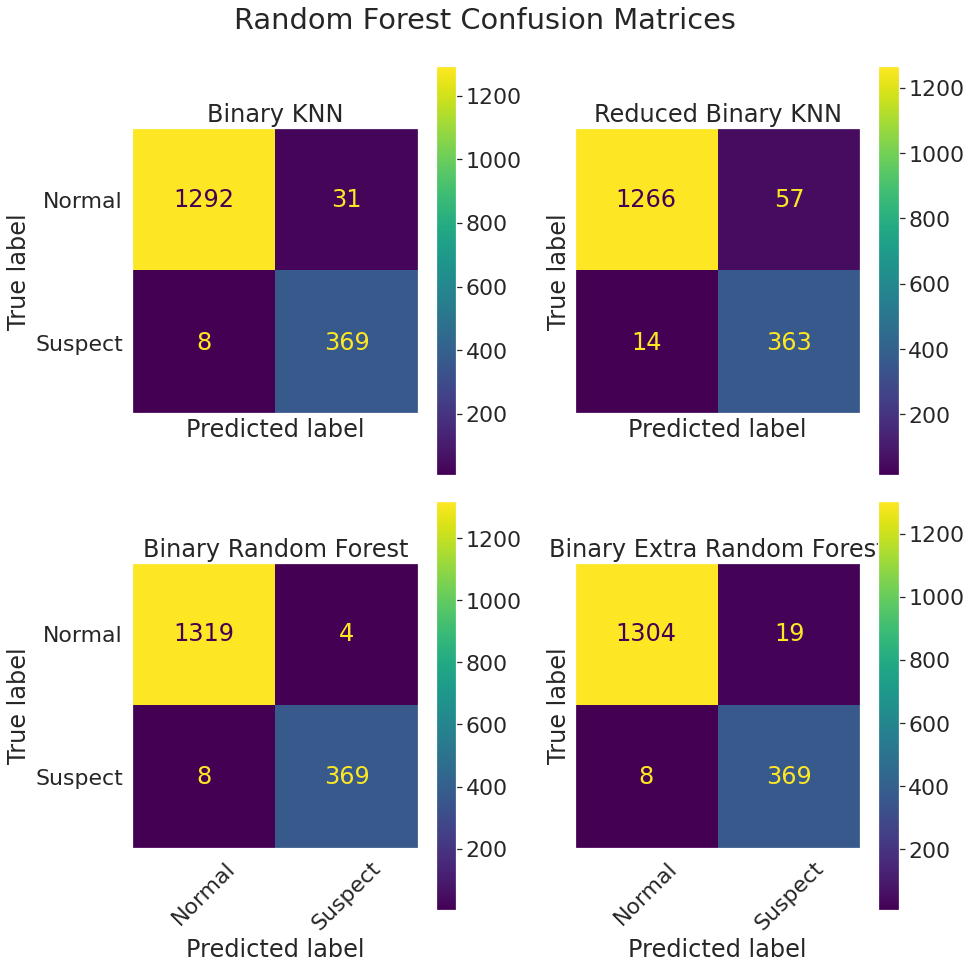

In [108]:
fig, ax = plt.subplots(2,2,figsize=(14,14),
                        sharex=True,sharey=True)

ConfusionMatrixDisplay.from_estimator(
            binary_knn_pipeline_gs.best_estimator_,
            X_train,y_train_bin,ax=ax[0,0])
ConfusionMatrixDisplay.from_estimator(
            reduced_binary_knn_pipeline_gs.best_estimator_,
            X_train_top_features,y_train_bin,ax=ax[0,1])
ConfusionMatrixDisplay.from_estimator(
            binary_tree_pipeline_gs.best_estimator_,
            X_train,y_train_bin,ax=ax[1,0])
ConfusionMatrixDisplay.from_estimator(
            binary_extra_tree_pipeline_gs.best_estimator_,
            X_train,y_train_bin,ax=ax[1,1])

ax[0,0].set(
    title='Binary KNN'
)
ax[0,1].set(
    title='Reduced Binary KNN'
)
ax[1,0].set(
    title='Binary Random Forest'
)
ax[1,1].set(
    title='Binary Extra Random Forest'
)

for ax_ in ax.flatten():
    ax_.grid(False)
    ax_.set(
        xticklabels=health_labels[:-1],
        yticklabels=health_labels[:-1]
    )
    ax_.xaxis.set_tick_params(rotation=45)


fig.suptitle("KNN Confusion Matrices")

plt.tight_layout()
'';

fig.suptitle("Random Forest Confusion Matrices")

plt.tight_layout()

display_table = model_scoring_table([
    scores_binary_knn_pipeline_gs,
    scores_reduced_binary_knn_pipeline_gs,
    scores_binary_tree_pipeline_gs,
    scores_binary_extra_tree_pipeline_gs
    ],[
        "Binary KNN Pipeline",
        "Binary Reduced KNN Pipeline",
        "Binary Random Forest Pipeline",
        "Binary Extra Random Forest Pipeline"
    ]
)
display(display_table['md'])

In [109]:
reduced_binary_knn_pipeline_gs.best_params_ , binary_tree_pipeline_gs.best_params_

({'knn__n_neighbors': 5, 'knn__p': 1, 'o__sampling_strategy': 0.6},
 {'o__sampling_strategy': 0.6,
  'rfc__max_depth': 9,
  'rfc__min_samples_split': 4})

Our Binary Random Forest Pipeline is ~0.02
higher than our previous best. In our case, that's
enough of an improvement to justify switching over to
the one of the new models. While this model may not
tell us if a CTG scan is showing the differences
between suspect or pathological, this model isn't able
to perform the tests necessary to make that distinction
on an individual level anyway. Anything that is at
least suspect should be investigated more thoroughly
through proper medical procedures and more direct
testing.